In [ ]:
# Dataset: Netflix Movie Recommendattion dataset on kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader

# Reading and merging the data

In [2]:
df_titles = pd.read_parquet('./data/movie_titles.parquet')

In [3]:
df_titles

,movie_id,year,title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17758,17766,2002,Where the Wild Things Are and Other Maurice Se...
17759,17767,2004,Fidel Castro: American Experience
17760,17768,2000,Epoch
17761,17769,2003,The Company


In [4]:
# Load ratings data from combined_data_1.txt
ratings_list = []
with open('./data/combined_data_1.txt', 'r') as file:
    movie_id = None
    for line in file:
        line = line.strip()
        if line.endswith(':'):
            movie_id = int(line[:-1])
        else:
            user_id, rating, date = line.split(',')
            ratings_list.append([int(user_id), movie_id, int(rating), date])

df_ratings = pd.DataFrame(ratings_list, columns=['user_id', 'movie_id', 'rating', 'date'])

In [5]:
df_ratings.head(3)

,user_id,movie_id,rating,date
0,1488844,1,3,2005-09-06
1,822109,1,5,2005-05-13
2,885013,1,4,2005-10-19


In [6]:
# Merge ratings with titles
df = pd.merge(df_ratings, df_titles, on='movie_id')

In [7]:
df.head(10)

,user_id,movie_id,rating,date,year,title
0,1488844,1,3,2005-09-06,2003,Dinosaur Planet
1,822109,1,5,2005-05-13,2003,Dinosaur Planet
2,885013,1,4,2005-10-19,2003,Dinosaur Planet
3,30878,1,4,2005-12-26,2003,Dinosaur Planet
4,823519,1,3,2004-05-03,2003,Dinosaur Planet
5,893988,1,3,2005-11-17,2003,Dinosaur Planet
6,124105,1,4,2004-08-05,2003,Dinosaur Planet
7,1248029,1,3,2004-04-22,2003,Dinosaur Planet
8,1842128,1,4,2004-05-09,2003,Dinosaur Planet
9,2238063,1,3,2005-05-11,2003,Dinosaur Planet


# Data Overview

In [8]:
print("Total ratings:", df.shape[0])
print("Total unique users:", df['user_id'].nunique())
print("Total unique movies:", df['movie_id'].nunique())
print("Missing values:\n", df.isnull().sum())

Total ratings: 24053575
Total unique users: 470758
Total unique movies: 4498
Missing values:
 user_id     0
movie_id    0
rating      0
date        0
year        0
title       0
dtype: int64


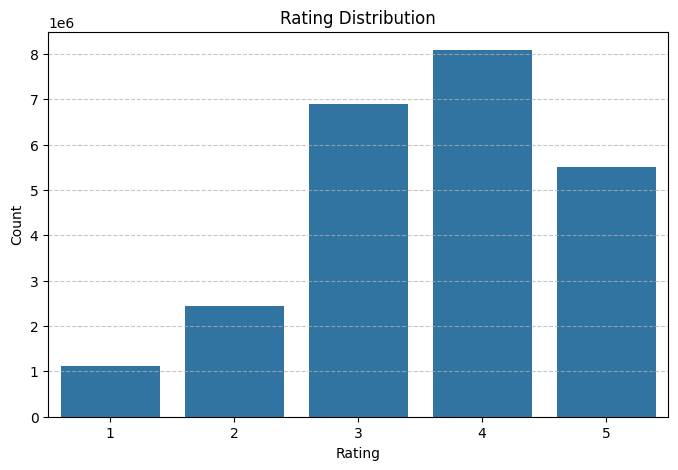

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

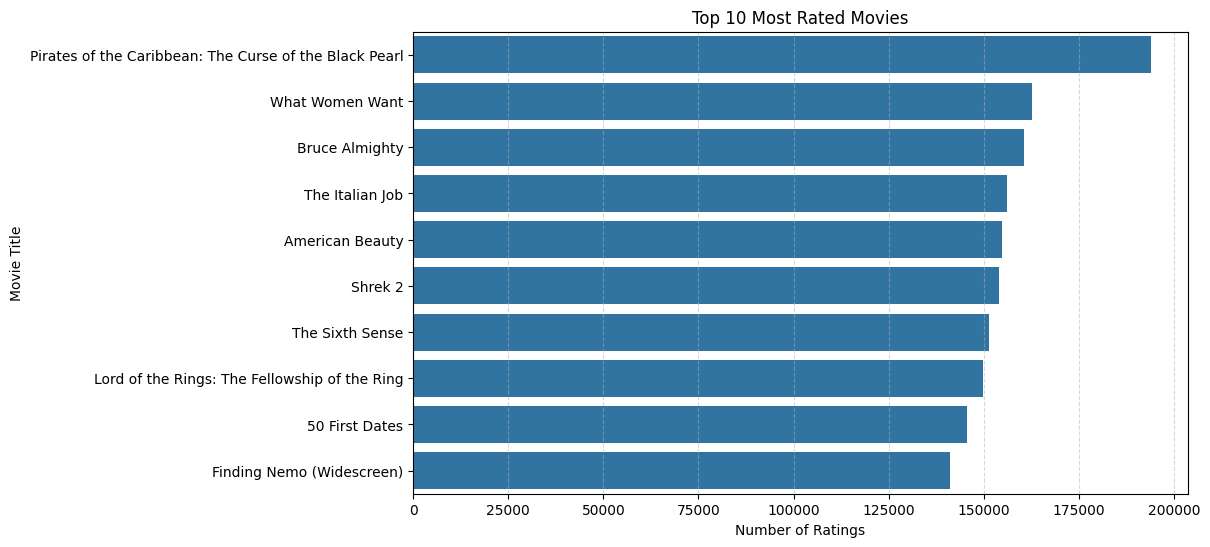

In [10]:
top_movies = df['title'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_movies.index, x=top_movies.values)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [11]:
top_ranked_movies = (
    df.groupby('movie_id')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Optional: add movie titles if available
top_ranked_movies = top_ranked_movies.merge(df_titles, on='movie_id', how='left')

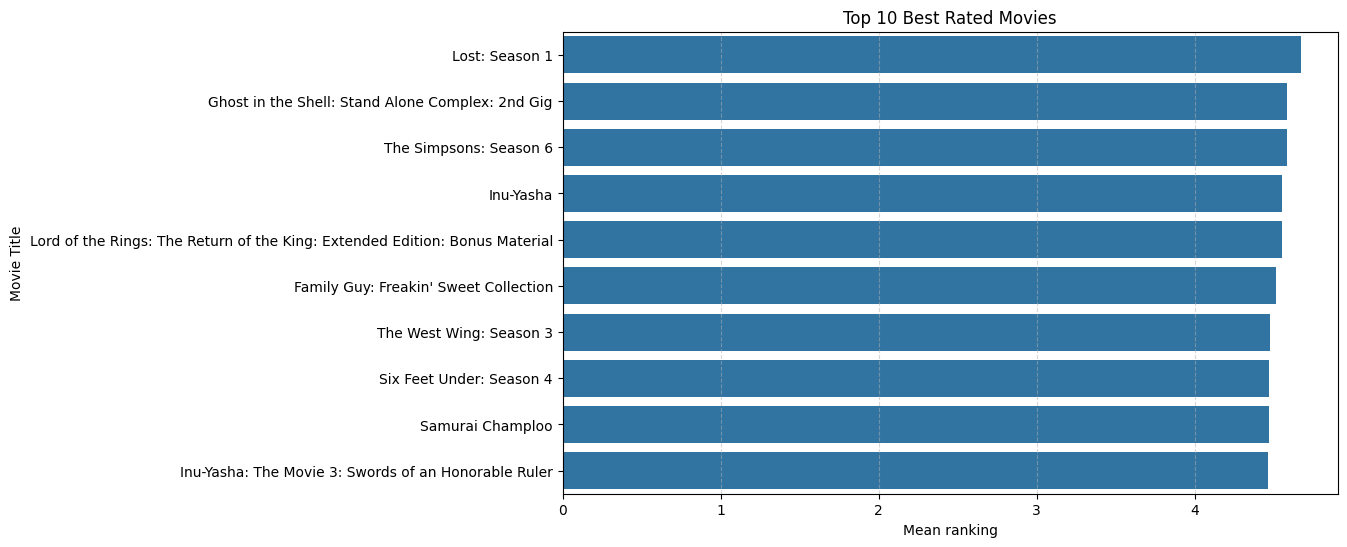

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(y=top_ranked_movies['title'], x=top_ranked_movies['rating'])
plt.title('Top 10 Best Rated Movies')
plt.xlabel('Mean ranking')
plt.ylabel('Movie Title')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Data Preprocessing

Let's select the most 10_000 active users

In [13]:
active_users = df['user_id'].value_counts().head(10_000).index
active_users = df[df['user_id'].isin(active_users)]

In [14]:
active_users.head(3)

,user_id,movie_id,rating,date,year,title
0,1488844,1,3,2005-09-06,2003,Dinosaur Planet
3,30878,1,4,2005-12-26,2003,Dinosaur Planet
7,1248029,1,3,2004-04-22,2003,Dinosaur Planet


In [15]:
user_movie_matrix = active_users.pivot_table(index='user_id', columns='title', values='rating', aggfunc='mean')

In [16]:
user_movie_matrix

title,'N Sync: 'N the Mix,'N Sync: PopOdyssey Live,... And God Spoke,10,10 Minute Solution: Pilates,10 Things I Hate About You,100 Days Before the Command,101 Dalmatians II: Patch's London Adventure,11:14,13 Ghosts,...,Zatoichi the Outlaw,Zatoichi's Conspiracy,Zeus and Roxanne,Zhou Yu's Train,Ziegfeld Girl,Zig Zag: Special Edition,Zigzag,Zombie 3,"Zorro, The Gay Blade",s-Cry-ed
user_id,,,,,,,,,,,,,,,,,,,,,
769,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1442,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2213,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2455,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648502,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2648589,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2648734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Apperantely, none of the users watched all the movies.

To start, we can fill Nans with zeros.

A better approach can be filling them using some algo, for instance, k-NN.

In [17]:
user_movie_matrix_zero = user_movie_matrix.fillna(0)

# Model 1- Cosine similarity - memory based collaborative filtering

The algorithm directly uses the raw user-item interaction data (like ratings or clicks) stored in memory — rather than learning a model from it.

**1. Collaborative filtering:**

This method generates recommendations by analyzing user-item interaction patterns and identifying users or items with similar behaviors. For example, if users who purchase noise-canceling headphones also tend to buy travel backpacks, the system would recommend a travel backpack to someone who buys noise-canceling headphones.

**In short** - if User 1 liked Item 1 and User 2 is similar to User 1, User 2 will also like Item 1.

**2. Content-based filtering**

This method recommends items by looking at what a user liked before and finding similar items. For example, if someone often buys noise-canceling headphones, the system might suggest other audio products with similar features.

**In short** - if User 1 liked Item 1 which is similar to Item 2, User 1 might also like Item 2.

# Modeling

**Compute user similarity - how each user similar to each other**

In [20]:
def compute_user_similarity(user_movie_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the cosine similarity matrix between users based on their movie ratings.

    Parameters:
        user_movie_matrix (pd.DataFrame): A user-item matrix with users as rows and movies as columns.
                                          Missing values should be filled with zeros or handled beforehand.

    Returns:
        pd.DataFrame: A user-user similarity DataFrame with user_id as both index and columns.
    """
    similarity = cosine_similarity(user_movie_matrix)
    similarity_df = pd.DataFrame(similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
    return similarity_df

In [21]:
df_user_similarity = compute_user_similarity(user_movie_matrix_zero)

In [22]:
df_user_similarity.head(5)

user_id,769,1333,1442,2213,2455,2469,2787,2905,2976,3321,...,2646634,2646766,2647197,2647559,2647888,2648502,2648589,2648734,2648869,2648885
user_id,,,,,,,,,,,,,,,,,,,,,
769,1.000000,0.383347,0.284653,0.362003,0.365455,0.298164,0.408191,0.264409,0.321260,0.312119,...,0.377141,0.373698,0.348181,0.407912,0.432910,0.319361,0.432760,0.350525,0.408881,0.418210
1333,0.383347,1.000000,0.278210,0.354466,0.355230,0.390832,0.275117,0.262655,0.368648,0.343623,...,0.294286,0.356206,0.325576,0.397461,0.289630,0.316744,0.455008,0.298757,0.434901,0.319155
1442,0.284653,0.278210,1.000000,0.430378,0.432793,0.420532,0.355859,0.405012,0.468697,0.439590,...,0.232493,0.377504,0.445229,0.329980,0.452056,0.290551,0.426965,0.415475,0.348926,0.436748
2213,0.362003,0.354466,0.430378,1.000000,0.487414,0.444303,0.415263,0.437249,0.522406,0.477900,...,0.295838,0.344552,0.446951,0.352463,0.443061,0.355907,0.464843,0.419447,0.380933,0.422069
2455,0.365455,0.355230,0.432793,0.487414,1.000000,0.510218,0.382397,0.453941,0.531270,0.437607,...,0.227055,0.338636,0.461188,0.367233,0.407369,0.401628,0.452146,0.489549,0.403979,0.366612


Now, we can find similar users for the specified user.

In [23]:
df_user_similarity[769].sort_values(ascending=False).head(10)

user_id
769        1.000000
1353855    0.560703
2358095    0.546229
2222874    0.540082
1550359    0.537657
694871     0.536570
2606334    0.536181
1674931    0.535838
2239067    0.535587
1432044    0.534788
Name: 769, dtype: float64

Now, let's create a function that gives recommendations for a specified user.

In [24]:
def extract_unseen_movie_features(
    user_id: int,
    ratings_df: pd.DataFrame,
    similarity_df: pd.DataFrame,
    top_k_users: int = 10
) -> pd.DataFrame:
    """
    Extracts features (similarity, weighted_rating) for unseen movies
    from top-K similar users for a given user.
    """

    # Top-K similar users
    similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False).head(top_k_users)
    similar_user_ids = similar_users.index

    # Ratings by similar users
    similar_ratings = ratings_df[ratings_df['user_id'].isin(similar_user_ids)]

    # Exclude movies already rated by the user
    seen_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].unique()
    unseen_ratings = similar_ratings[~similar_ratings['movie_id'].isin(seen_movies)].copy()

    # Add similarity and weighted rating
    unseen_ratings['similarity'] = unseen_ratings['user_id'].map(similar_users)
    unseen_ratings['weighted_rating'] = unseen_ratings['rating'] * unseen_ratings['similarity']

    return unseen_ratings

In [25]:
unseen_movies = extract_unseen_movie_features(user_id=769, ratings_df=df_ratings, similarity_df=df_user_similarity, top_k_users=10)
unseen_movies

,user_id,movie_id,rating,date,similarity,weighted_rating
2256,1550359,3,2,2004-08-09,0.537657,1.075313
8981,2606334,8,2,2005-07-20,0.536181,1.072363
16789,1550359,8,4,2005-08-16,0.537657,2.150626
18384,2222874,8,3,2005-05-22,0.540082,1.620245
33983,1353855,18,4,2005-04-11,0.560703,2.242812
...,...,...,...,...,...,...
23975528,2606334,4483,5,2005-09-22,0.536181,2.680907
23975668,2504544,4483,5,2002-09-06,0.531890,2.659448
24050279,1550359,4496,5,2003-07-17,0.537657,2.688283
24051071,2239067,4496,5,2005-12-29,0.535587,2.677937


In [26]:
def infer_user_recommendations(
    unseen_movies: pd.DataFrame,
    titles_df: pd.DataFrame = None,
    top_n_movies: int = 10
) -> pd.DataFrame:
    """
    Ranks and returns top-N movie recommendations based on weighted ratings
    computed from similar users.

    Parameters:
        unseen_movies (pd.DataFrame): DataFrame containing at least 'movie_id', 'weighted_rating', and 'similarity'.
        titles_df (pd.DataFrame, optional): Movie metadata with 'movie_id' and other info like 'Name'.
        top_n_movies (int): Number of top recommendations to return.

    Returns:
        pd.DataFrame: Recommended movies with scores (and metadata if provided).
    """

    # Aggregate scores using weighted mean
    recommendations = (
        unseen_movies.groupby('movie_id')
        .agg(
            weighted_sum=('weighted_rating', 'sum'),
            sim_sum=('similarity', 'sum')
        )
    )

    # Compute final score
    recommendations['score'] = recommendations['weighted_sum'] / (recommendations['sim_sum'] + 1e-8)

    # Select top N
    recommendations = (
        recommendations
        .sort_values('score', ascending=False)
        .head(top_n_movies)
        .reset_index()
    )

    # Merge with titles if provided
    if titles_df is not None:
        recommendations = recommendations.merge(titles_df, on='movie_id', how='left')

    # Return final result
    base_columns = ['movie_id', 'score']
    extra_columns = [col for col in titles_df.columns if col != 'movie_id'] if titles_df is not None else []
    return recommendations[base_columns + extra_columns]

In [27]:
recommendations = infer_user_recommendations(unseen_movies, titles_df=df_titles, top_n_movies=10)

recommendations

,movie_id,score,year,title
0,4115,5.0,1999,The Simpsons: Bart Wars
1,722,5.0,2003,The Wire: Season 1
2,1923,5.0,1986,Pee-Wee's Playhouse: Vol. 1
3,1495,5.0,2001,Alias: Season 1
4,4483,5.0,2000,Human Traffic
5,825,5.0,1983,Bill Cosby: Himself
6,133,5.0,2003,Viva La Bam: Season 1
7,3965,5.0,1992,Red Dwarf: Series 5
8,4185,5.0,1989,The Kids in the Hall: Season 1
9,3668,5.0,2000,Farscape: Season 2


# Matrix Factorization - model based collaborative filtering

**What Does Matrix Factorization (SVD) Do?**

We use Matrix Factorization, specifically SVD - Singular Matrix Decomposition, from the surprise library, to predict how users might rate movies they haven’t rated yet.

**Inputs & Targets**

**Input:** Known (user_id, movie_id, rating) triples

**Example:** ("user_12", "movie_42", 4.5)

**Target:**'

Predict missing ratings:
model.predict("user_12", "movie_99") → 3.8

**How It Works**

SVD factorizes the user-item rating matrix R into two lower-dimensional matrices:

R ≈ P × Qᵀ

P: user latent features (preferences)

Q: item latent features (characteristics)

Predict the missing values in the user-item matrix:

How much a user would like a video they haven’t seen.

**Output:** Predicted rating or ranking score (The dot product P[user] • Q[movie] gives the predicted rating.)

**RMSE (Root Mean Squared Error)**

RMSE measures how close predicted ratings are to actual ratings.

# Preprocessing

In [26]:
reader = Reader(rating_scale=(1, 5))  # Can be adjusted to your rating scale
data = Dataset.load_from_df(active_users[['user_id', 'movie_id', 'rating']], reader)

# Training

In [27]:
%%time
# Split the data
train_set, test_set = train_test_split(data, test_size=0.2)

# Train SVD model
model = SVD()
model.fit(train_set)

CPU times: user 22.2 s, sys: 120 ms, total: 22.3 s
Wall time: 22.4 s


In [28]:
%%time
# Predict on testset
predictions = model.test(test_set)
print('RMSE:', accuracy.rmse(predictions))

RMSE: 0.8224
RMSE: 0.8224009170431237
CPU times: user 1.64 s, sys: 45.5 ms, total: 1.68 s
Wall time: 1.73 s


# Inference

In [29]:
def recommend_svd(
    user_id: Union[int, str],
    model: SVD,
    df: pd.DataFrame,
    titles_df: pd.DataFrame,
    n: int = 10
) -> pd.DataFrame:
    """
    Recommend top-N movies for a specific user using a trained SVD model from the Surprise library.

    Parameters:
        user_id (int or str): ID of the target user.
        model (surprise.SVD): A trained SVD model from the Surprise library.
        df (pd.DataFrame): DataFrame containing user-movie interactions. Must include columns 'user_id', 'movie_id', and 'rating'.
        titles_df (pd.DataFrame): DataFrame with movie metadata. Must include a 'movie_id' column and optional metadata like 'Name', 'Genres', etc.
        n (int, optional): Number of top movie recommendations to return. Default is 10.

    Returns:
        pd.DataFrame: A DataFrame containing the top-N recommended movies, including predicted ratings and optional metadata.
    """

    # Get all unique movie IDs
    all_movie_ids = df['movie_id'].unique()

    # Get movies already rated by the user
    rated = df[df['user_id'] == user_id]['movie_id'].values

    # Initialize list to store predictions
    predictions = []

    # Predict ratings for unseen movies
    for movie_id in all_movie_ids:
        if movie_id not in rated:
            prediction = model.predict(user_id, movie_id)
            estimated_rating = prediction.est
            predictions.append((movie_id, estimated_rating))

    # Sort predictions by estimated rating in descending order
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]

    # Convert to DataFrame
    top_df = pd.DataFrame(top_n, columns=['movie_id', 'predicted_rating'])

    # Merge with movie titles for readability
    top_df = top_df.merge(titles_df, on='movie_id', how='left')

    return top_df

In [30]:
recommendations_svd = recommend_svd(user_id=769, model=model, df = active_users, titles_df=df_titles, n=10)

Let's compare collaborative filtering with Matrix Factorization

In [31]:
print('Cosine similarity filtering')
recommendations

Cosine similarity filtering


,movie_id,score,year,title
0,4115,5.0,1999,The Simpsons: Bart Wars
1,722,5.0,2003,The Wire: Season 1
2,1923,5.0,1986,Pee-Wee's Playhouse: Vol. 1
3,1495,5.0,2001,Alias: Season 1
4,4483,5.0,2000,Human Traffic
5,825,5.0,1983,Bill Cosby: Himself
6,133,5.0,2003,Viva La Bam: Season 1
7,3965,5.0,1992,Red Dwarf: Series 5
8,4185,5.0,1989,The Kids in the Hall: Season 1
9,3668,5.0,2000,Farscape: Season 2


In [32]:
print('Matrix Factorization')
recommendations_svd

Matrix Factorization


,movie_id,predicted_rating,year,title
0,872,4.394036,1954,Seven Samurai
1,2111,4.378192,1968,The Twilight Zone: Vol. 33
2,2102,4.377867,1994,The Simpsons: Season 6
3,3425,4.327941,1990,GoodFellas: Special Edition: Bonus Material
4,1291,4.310536,1960,The Twilight Zone: Vol. 19
5,1208,4.307123,1963,The Twilight Zone: Vol. 15
6,4353,4.299634,2002,Curb Your Enthusiasm: Season 3
7,1277,4.270028,1988,Red Dwarf: Series 3
8,3487,4.249951,1963,The Twilight Zone: Vol. 16
9,463,4.245536,1962,The Twilight Zone: Vol. 12


In [33]:
for movie in recommendations['title']:
    if movie in recommendations_svd['title'].tolist():
        print(f'{movie} is recommended by both models')

# Conclusions

- We implemented 2 simple recommendation models - similarity based and Matrix Factorization
- We can compute RMSE on the test set for cos similarity and compare the algorithms.